In [1]:
import os
import json
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon
import pandas as pd
import numpy as np
import xarray as xr
import rioxarray as rxr
import geoviews as gv
import geoviews.feature as gf
import hvplot.pandas
import s3fs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from multiprocessing import Pool, cpu_count
import dask
from dask.distributed import Client, progress, LocalCluster
import dask.array as da
import geopandas as gpd

In [2]:
# THIS IS FROM EMMA's TUTORIAL https://github.com/e-marshall/itslivetools/blob/main/itslivetools/access.py
def find_granule_by_point(input_point, label='single_point'):
    '''returns url for the granule (zarr datacube) containing a specified point. point must be passed in epsg:4326
    '''
    catalog = gpd.read_file('https://its-live-data.s3.amazonaws.com/datacubes/catalog_v02.json')

    #make shapely point of input point
    p = gpd.GeoSeries([Point(input_point[0], input_point[1])],crs='EPSG:4326')
    #make gdf of point
    gdf = gdf = gpd.GeoDataFrame({'label': f'{label}', 
                                  'geometry':p})

    #find row of granule 
    granule = catalog.sjoin(gdf, how='inner')

    url = granule['zarr_url'].values[0]
    return url
    
def read_in_s3(http_url, chunks='auto'):
    ''' does some string formatting from zarr url and returns xarray dataset
    '''

    s3_url = http_url.replace('http','s3')
    s3_url = s3_url.replace('.s3.amazonaws.com','')

    datacube = xr.open_dataset(s3_url, engine='zarr',
                               storage_options={'anon':True},
                               chunks=chunks,
                              # lock=False
                              )

    # datacube = rxr.open_rasterio(s3_url, engine='zarr',
    #                            storage_options={'anon':True},
    #                            chunks=chunks)
    
    return datacube


In [3]:
catalog = gpd.read_file('https://its-live-data.s3.amazonaws.com/datacubes/catalog_v02.json') # ITS_LIVE data catalog where all the paths are defined
path = './geoms/2020_12_11_term_polygon.shp'
kuj_poly = gpd.read_file(path)
kuj_centroid = kuj_poly.centroid
kuj_centroid = gpd.GeoDataFrame(geometry=kuj_centroid)#,crs=4326)
granule = catalog.sjoin(kuj_centroid, how='inner')
url = granule['zarr_url'].values[0]

kuj_vels = read_in_s3(url)
kuj_vels = kuj_vels.chunk({"mid_date": len(kuj_vels.mid_date)}) # setting the mid_date chunksize to the time dimensions helps A LOT
kuj_vels = kuj_vels.sortby('mid_date')
kuj_vels.rio.write_crs('EPSG:3413',inplace=True)

/tmp/ipykernel_7910/2972028994.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  kuj_centroid = kuj_poly.centroid


<xarray.Dataset>
Dimensions:                     (mid_date: 49475, y: 834, x: 833)
Coordinates:
    mapping                     int64 0
  * mid_date                    (mid_date) datetime64[ns] 1984-10-21T14:23:16...
  * x                           (x) float64 -1.999e+05 -1.997e+05 ... -1e+05
  * y                           (y) float64 -2.1e+06 -2.1e+06 ... -2.2e+06
Data variables: (12/59)
    M11                         (mid_date, y, x) float32 dask.array<chunksize=(49475, 20, 20), meta=np.ndarray>
    M11_dr_to_vr_factor         (mid_date) float32 dask.array<chunksize=(49475,), meta=np.ndarray>
    M12                         (mid_date, y, x) float32 dask.array<chunksize=(49475, 20, 20), meta=np.ndarray>
    M12_dr_to_vr_factor         (mid_date) float32 dask.array<chunksize=(49475,), meta=np.ndarray>
    acquisition_date_img1       (mid_date) datetime64[ns] dask.array<chunksize=(49475,), meta=np.ndarray>
    acquisition_date_img2       (mid_date) datetime64[ns] dask.array<chunksize=(49475,), meta=np.ndarray>
    ...                          ...
    vy_error_modeled            (mid_date) float32 dask.array<chunksize=(49475,), meta=np.ndarray>
    vy_error_slow               (mid_date) float32 dask.array<chunksize=(49475,), meta=np.ndarray>
    vy_error_stationary         (mid_date) float32 dask.array<chunksize=(49475,), meta=np.ndarray>
    vy_stable_shift             (mid_date) float32 dask.array<chunksize=(49475,), meta=np.ndarray>
    vy_stable_shift_slow        (mid_date) float32 dask.array<chunksize=(49475,), meta=np.ndarray>
    vy_stable_shift_stationary  (mid_date) float32 dask.array<chunksize=(49475,), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               26-Sep-2023 03:06:33
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N70W040/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N70W040/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

### Here I created a merged polygon of all the terminus polygons of Kuj that I had. Maybe there are more, but having a sinlge file (in my experience preferably geopackage for larger data) makes everything much simpler 

In [4]:
term_polys_path = '/media/laserglaciers/upernavik/its_live_tutorial/merged_geoms/kuj_merged.gpkg'
term_polys = gpd.read_file(term_polys_path)

/home/laserglaciers/anaconda3/envs/its_live_tutorial/lib/python3.10/site-packages/geopandas/io/file.py:399: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  as_dt = pd.to_datetime(df[k], errors="ignore")


In [5]:
term_polys

,date,geometry
0,1975-05-28,"POLYGON ((-199287.272 -2181829.050, -201340.29..."
1,1976-05-03,"POLYGON ((-199397.285 -2181891.815, -201290.87..."
2,1978-07-03,"POLYGON ((-199510.281 -2181658.001, -201350.32..."
3,1985-03-29,"POLYGON ((-199663.310 -2181698.266, -201334.74..."
4,1985-04-14,"POLYGON ((-198851.917 -2176593.291, -196540.73..."
...,...,...
920,2021-05-13,"POLYGON ((-199028.903 -2181622.914, -201356.83..."
921,2021-05-17,"POLYGON ((-199082.570 -2181648.338, -201353.84..."
922,2021-05-18,"POLYGON ((-199050.566 -2181721.063, -201344.33..."
923,2021-05-21,"POLYGON ((-199043.882 -2181592.987, -201424.24..."


### Here I rely on numpy to filter out the matching dates between the its_live data cube and terminus polygons
### the np.where(np.isin(kj_dates,term_dates_pd)) statement is very efficient for this

In [6]:
kj_dates = kuj_vels.mid_date.dt.date.data # get the mid_dates
term_dates_pd = term_polys['date'].dt.date.values # get the polygon dates
matched_idx = np.where(np.isin(kj_dates,term_dates_pd))[0] # returns the indices of the matched dates so we can just use an isel (integer select) on the data cube
kuj_vels = kuj_vels.isel(mid_date=matched_idx) # use isel to grab the data we want

In [7]:
kuj_vels

<xarray.Dataset>
Dimensions:                     (mid_date: 9803, y: 834, x: 833)
Coordinates:
    mapping                     int64 0
  * mid_date                    (mid_date) datetime64[ns] 1985-03-29T14:30:57...
  * x                           (x) float64 -1.999e+05 -1.997e+05 ... -1e+05
  * y                           (y) float64 -2.1e+06 -2.1e+06 ... -2.2e+06
Data variables: (12/59)
    M11                         (mid_date, y, x) float32 dask.array<chunksize=(9803, 20, 20), meta=np.ndarray>
    M11_dr_to_vr_factor         (mid_date) float32 dask.array<chunksize=(9803,), meta=np.ndarray>
    M12                         (mid_date, y, x) float32 dask.array<chunksize=(9803, 20, 20), meta=np.ndarray>
    M12_dr_to_vr_factor         (mid_date) float32 dask.array<chunksize=(9803,), meta=np.ndarray>
    acquisition_date_img1       (mid_date) datetime64[ns] dask.array<chunksize=(9803,), meta=np.ndarray>
    acquisition_date_img2       (mid_date) datetime64[ns] dask.array<chunksize=(9803,), meta=np.ndarray>
    ...                          ...
    vy_error_modeled            (mid_date) float32 dask.array<chunksize=(9803,), meta=np.ndarray>
    vy_error_slow               (mid_date) float32 dask.array<chunksize=(9803,), meta=np.ndarray>
    vy_error_stationary         (mid_date) float32 dask.array<chunksize=(9803,), meta=np.ndarray>
    vy_stable_shift             (mid_date) float32 dask.array<chunksize=(9803,), meta=np.ndarray>
    vy_stable_shift_slow        (mid_date) float32 dask.array<chunksize=(9803,), meta=np.ndarray>
    vy_stable_shift_stationary  (mid_date) float32 dask.array<chunksize=(9803,), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               26-Sep-2023 03:06:33
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N70W040/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N70W040/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

### We can also filter based on time seperation between two images 

In [8]:
days = kuj_vels.date_dt.compute() # get the dt_array
days = days.data.astype('timedelta64[D]') # convert to days using .astype
day_filter = np.timedelta64(100, 'D') # the day separation we filter by
matched_date_dt_idx = np.where(days<=day_filter)[0] # get this indices 
kuj_vels = kuj_vels.isel(mid_date=matched_date_dt_idx) # use isel to grab the data we want

In [9]:
kuj_vels

<xarray.Dataset>
Dimensions:                     (mid_date: 4804, y: 834, x: 833)
Coordinates:
    mapping                     int64 0
  * mid_date                    (mid_date) datetime64[ns] 1985-03-29T14:30:57...
  * x                           (x) float64 -1.999e+05 -1.997e+05 ... -1e+05
  * y                           (y) float64 -2.1e+06 -2.1e+06 ... -2.2e+06
Data variables: (12/59)
    M11                         (mid_date, y, x) float32 dask.array<chunksize=(4804, 20, 20), meta=np.ndarray>
    M11_dr_to_vr_factor         (mid_date) float32 dask.array<chunksize=(4804,), meta=np.ndarray>
    M12                         (mid_date, y, x) float32 dask.array<chunksize=(4804, 20, 20), meta=np.ndarray>
    M12_dr_to_vr_factor         (mid_date) float32 dask.array<chunksize=(4804,), meta=np.ndarray>
    acquisition_date_img1       (mid_date) datetime64[ns] dask.array<chunksize=(4804,), meta=np.ndarray>
    acquisition_date_img2       (mid_date) datetime64[ns] dask.array<chunksize=(4804,), meta=np.ndarray>
    ...                          ...
    vy_error_modeled            (mid_date) float32 dask.array<chunksize=(4804,), meta=np.ndarray>
    vy_error_slow               (mid_date) float32 dask.array<chunksize=(4804,), meta=np.ndarray>
    vy_error_stationary         (mid_date) float32 dask.array<chunksize=(4804,), meta=np.ndarray>
    vy_stable_shift             (mid_date) float32 dask.array<chunksize=(4804,), meta=np.ndarray>
    vy_stable_shift_slow        (mid_date) float32 dask.array<chunksize=(4804,), meta=np.ndarray>
    vy_stable_shift_stationary  (mid_date) float32 dask.array<chunksize=(4804,), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                CF-1.8
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               26-Sep-2023 03:06:33
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v2/N70W040/ITS_L...
    skipped_granules:           s3://its-live-data/datacubes/v2/N70W040/ITS_L...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

### This is the main function that clips and counts the number of pixels for the mask area %

In [10]:
def rio_clip(dataset,gdf,date_list,crs):
    velocity = []
    area = []
    for date in date_list:
        geom_values = gdf[gdf['date'] == pd.to_datetime(date.date())].geometry.values
        dataset_sample_clip = dataset.v.sel(mid_date=date).rio.clip(geom_values,crs,drop=True,invert=False)
        mean_arr = dataset_sample_clip.mean(dim=["x", "y"],skipna=True)
        area_count = dataset_sample_clip.count(dim=["x", "y"]) #,skipna=True) This should not count NaNs
        
        velocity.append(mean_arr)
        area.append(area_count)
        
    return area, velocity

In [11]:
date_list = pd.to_datetime(kuj_vels.mid_date) #creates a list which we will split up to divide the parallelized work 

### Splitting up the data can be tricky and depends on the number of cores and memory you plan to run it on. This worked for me to get through SOME of the data

In [12]:
split_size = 100
date_lists = [date_list[x:x+split_size] for x in range(0, len(date_list), split_size)]

In [13]:
len(date_lists)

49

### args stores the arguments to run in the multiproccessing pool. Noticed how I only did the first 4 date_lists entries. I was having trouble with running out of memory using the full list

In [14]:
args = []
crs = term_polys.crs
for date_list in date_lists:
    args.append((kuj_vels,term_polys,date_list,crs))

In [15]:
date_lists

[DatetimeIndex(['1985-03-29 14:30:57.925833024',
                '1985-04-14 14:30:54.476366976',
                '1985-04-30 14:30:49.844966976',
                '1985-04-30 14:30:51.235932032',
                '1985-06-15 14:42:39.749580032',
                '1985-07-03 14:30:35.615649024',
                '1985-07-09 14:42:27.567102016',
                   '1985-07-09 14:42:32.756688',
                '1985-07-09 14:42:33.616228928',
                   '1985-08-02 14:42:16.918160',
                '1985-08-02 14:42:19.160264064',
                '1985-08-02 14:42:20.493289024',
                '1985-08-02 14:42:21.433766976',
                '1985-08-18 14:42:10.894275968',
                '1985-08-18 14:42:35.615820992',
                '1986-04-17 14:25:59.019940992',
                '1987-05-06 14:24:08.975955008',
                '1987-08-24 14:38:52.512883968',
                '1988-04-04 14:42:39.881410048',
                '1988-04-20 14:42:47.781388032',
                '198

### `result` stores the output of the `rio_clip` function as lists of dask arrays ready to be computed

In [16]:
with Pool(processes=cpu_count()-4) as pool:
    result = pool.starmap(rio_clip, args)
    

### Now we have to reorginize the data. `results` is organized like this `results[i][0]` are the lists where the pixel count dask arrays are stored. `results[i][1]` are where the velocity averages are stored. The cell below uses `xr.concat` to combine all the pixel counts and the velocity means into their own xarray data arrays

In [17]:
computed_pixel_count = []
for i in range(0,len(result)):
    computed = dask.compute(*result[i][0])
    computed_pixel_count.append(computed)
    
computed_mean_vel = []
for i in range(0,len(result)):
    computed_vel = dask.compute(*result[i][1])
    computed_mean_vel.append(computed_vel)



### Now we need to reduce from a list of tuples to just a single list for each data variable

In [18]:
computed_pixel_count_explode = [item for t in computed_pixel_count for item in t]
computed_vel_explode = [item for t in computed_mean_vel for item in t]

In [19]:
computed_vel_explode[1]

<xarray.DataArray 'v' ()>
array(3125.6294, dtype=float32)
Coordinates:
    mid_date  datetime64[ns] 1985-04-14T14:30:54.476366976
    mapping   int64 0

### Now we use `xarray.concat` to create our data arrays

In [20]:
pixel_count = xr.concat(computed_pixel_count_explode,"mid_date").rename('area_count') # this creates one big data array
v_mean = xr.concat(computed_vel_explode,"mid_date").rename('v_mean') # this creates one big data array

In [21]:
v_mean

<xarray.DataArray 'v_mean' (mid_date: 7598)>
array([      nan, 3125.6294, 3065.307 , ...,       nan,       nan,
             nan], dtype=float32)
Coordinates:
  * mid_date  (mid_date) datetime64[ns] 1985-03-29T14:30:57.925833024 ... 202...
    mapping   int64 0

### To create a single dataset we use `xarray merge`

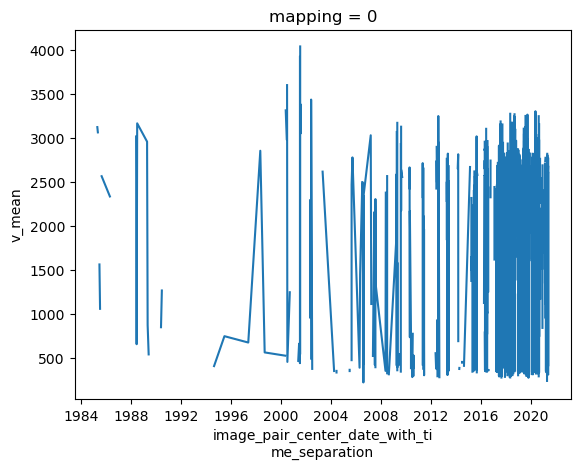

In [22]:
area_vel_merge = xr.merge([pixel_count,v_mean])
area_vel_merge.v_mean.plot()

### The resulting dataset has both the area_count and v_mean stored together and tied to the same `mid_date` coordinate. 

### Now let's do the pixel area mask filtering 

### First calculate area of the terminus polygons from the geodataframe

In [23]:
term_polys['area'] = term_polys.area
term_polys

,date,geometry,area
0,1975-05-28,"POLYGON ((-199287.272 -2181829.050, -201340.29...",1.271553e+07
1,1976-05-03,"POLYGON ((-199397.285 -2181891.815, -201290.87...",1.303055e+07
2,1978-07-03,"POLYGON ((-199510.281 -2181658.001, -201350.32...",1.249199e+07
3,1985-03-29,"POLYGON ((-199663.310 -2181698.266, -201334.74...",1.289889e+07
4,1985-04-14,"POLYGON ((-198851.917 -2176593.291, -196540.73...",1.261392e+07
...,...,...,...
920,2021-05-13,"POLYGON ((-199028.903 -2181622.914, -201356.83...",1.225670e+07
921,2021-05-17,"POLYGON ((-199082.570 -2181648.338, -201353.84...",1.230120e+07
922,2021-05-18,"POLYGON ((-199050.566 -2181721.063, -201344.33...",1.251376e+07
923,2021-05-21,"POLYGON ((-199043.882 -2181592.987, -201424.24...",1.214293e+07


### We need to get the dates from the mid_date of the `area_vel_merge` dataset we just created and the terminus polygon dataframe

In [24]:
mid_date_arr = area_vel_merge.mid_date.dt.date.data
term_poly_dates = term_polys.date.dt.date
# c = np.where(np.isin(term_poly_dates,mid_date_arr))[0]

### Let's just get the data we need and merge the mid_dates from `area_vel_merge` with the `term_polys` geodataframe using `.loc`

In [25]:
term_poly_area = term_polys[['date','area']]
term_poly_area.set_index(['date'],inplace=True)
term_poly_area = term_poly_area.loc[mid_date_arr]
term_poly_area['mid_date'] = area_vel_merge.mid_date.data
term_poly_area.set_index(['mid_date'],inplace=True)
term_poly_area

,area
mid_date,
1985-03-29 14:30:57.925833024,1.289889e+07
1985-04-14 14:30:54.476366976,1.261392e+07
1985-04-30 14:30:49.844966976,1.262805e+07
1985-04-30 14:30:51.235932032,1.262805e+07
1985-06-15 14:42:39.749580032,1.255734e+07
...,...
2021-05-27 15:38:09.210507008,1.229403e+07
2021-05-27 15:38:09.210516736,1.229403e+07
2021-05-27 15:39:06.210501888,1.229403e+07


### We did it! Now we need to 1) combine the polygon area to the `area_vel_merge` dataset, 2) calculate the pixel overlap percentage, 3) filter then plot

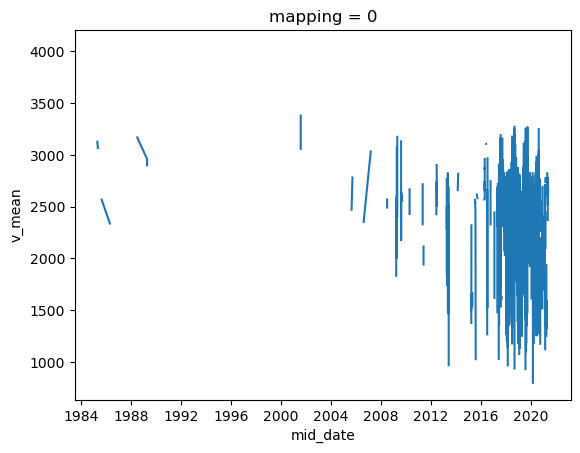

In [31]:
term_poly_area_xr_dataset = term_poly_area.to_xarray()
pixel_size = kuj_vels.rio.transform()[0]
area_vel_merge['poly_area'] = term_poly_area_xr_dataset.area
area_vel_merge['pixel_area'] = area_vel_merge.area_count * (pixel_size **2)
area_vel_merge['pixel_overlap'] = area_vel_merge.pixel_area/area_vel_merge.poly_area
area_vel_merge.where(area_vel_merge.pixel_overlap >0.20).v_mean.plot()

### The data looks sparse, it might be bc of the terminus polygons I am using/mising?
### We can also save as a csv :)

In [32]:
#area_vel_merge.to_dataframe().to_csv()

,mapping,area_count,v_mean,poly_area,pixel_area,pixel_overlap
mid_date,,,,,,
1985-03-29 14:30:57.925833024,0,0,NaN,1.289889e+07,0.0,0.000000
1985-04-14 14:30:54.476366976,0,437,3125.629395,1.261392e+07,6292800.0,0.498878
1985-04-30 14:30:49.844966976,0,365,3065.306885,1.262805e+07,5256000.0,0.416216
1985-04-30 14:30:51.235932032,0,0,NaN,1.262805e+07,0.0,0.000000
1985-06-15 14:42:39.749580032,0,165,1563.115112,1.255734e+07,2376000.0,0.189212
...,...,...,...,...,...,...
2021-05-27 15:38:09.210507008,0,0,NaN,1.229403e+07,0.0,0.000000
2021-05-27 15:38:09.210516736,0,0,NaN,1.229403e+07,0.0,0.000000
2021-05-27 15:39:06.210501888,0,0,NaN,1.229403e+07,0.0,0.000000
